In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

df = pd.read_csv("../data/cannabis.csv")

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
df.head()

,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%..."


In [3]:
df.shape

(2351, 6)

### Data Exploration

In [4]:
# How many NANs descriptions are there?

In [5]:
df.isnull().sum()

Strain          0
Type            0
Rating          0
Effects         0
Flavor         46
Description    33
dtype: int64

We will try to combine the effects and descriptions columns on the next improved model.

In [6]:
df = df.dropna(subset=['Description'])

In [7]:
df.shape

(2318, 6)

In [8]:
#How many strains of cannabis are there?

In [9]:
strains = list(set(df['Strain']))
len(strains)

2317

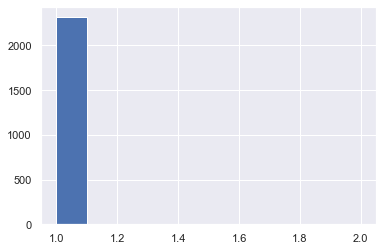

In [11]:
# Is there an even distribution of strain types?
strains = df['Strain'].value_counts()
strains.hist()

In [13]:
# What types of Cannabis are there?
types = list(set(df['Type']))
len(types)

3

In [14]:
type_count = df['Type'].value_counts()
type_count

hybrid    1193
indica     689
sativa     436
Name: Type, dtype: int64

### Baseline ML Model

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [16]:
from sklearn.model_selection import train_test_split

X = df['Description']
y = df['Strain']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1000)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1854,), (464,), (1854,), (464,))

In [18]:
model.fit(X_train, y_train)
labels = model.predict(X_test)

In [ ]:
#How good is the model on the test data?

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

labels_names = list(set(df['Type']))

mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x112f60170> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1131e0680> (for post_execute):


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report
y_true = y_test
y_pred = labels
target_names = labels_names
print(classification_report(y_true, y_pred, target_names=target_names))

Using the Cannabis description to predict the type of Cannabis via a simple Multinominal Naive Bayes Model performed poorly with an accuracy of ~36%. It may be concluded that the types of Cannabis do not share enough unique words to allow the model to predict the correct type.

To improve this model we will try to combine the effects column with the description column.

The approach to trying to predict the type of Cannabis may be the wrong approach.

### Model 2

In [ ]:
# What unique effect words are there?

In [27]:
import nltk
from nltk.tokenize import word_tokenize

effect_types = []

for effect in df['Effects']:
    #Get all the sentences
    #print(effect)
    #effect_types.append(effect)
    sentence = word_tokenize(effect)
    for word in sentence:
        effect_types.append(word)
    

In [28]:
effect_types = list(set(effect_types))

In [29]:
len(effect_types)

17

In [31]:
effect_types

['Relaxed',
 'Euphoric',
 'Talkative',
 'Tingly',
 'Aroused',
 'None',
 'Sleepy',
 'Uplifted',
 'Happy',
 'Dry',
 'Energetic',
 'Creative',
 'Giggly',
 ',',
 'Hungry',
 'Focused',
 'Mouth']

There are 1630 unique effect word combinations to describe a certain strain of Cannabis. A better approach would be to cluster the description and effect into categories

### Clustering

In [40]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
from spacy.tokenizer import Tokenizer

tfidf = TfidfVectorizer(stop_words = 'english')

sparse = tfidf.fit_transform(X_train)

# send the matrix to a DataFrame
tfidf_dtm = pd.DataFrame(sparse.todense(), columns = tfidf.get_feature_names())

# Instantiate nearest neighbors model
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(tfidf_dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

Test kmeans model

In [45]:
X_test[2268]

'White Cheese from Zambeza Seeds is an indica-dominant hybrid that crosses Super Skunk and Afghani\xa0genetics. It carries the skunky cheese aroma with an earthy note and provides relaxing indica effects without being a total knock-out. Its euphoric buzz keeps away stress and anxiety. The short flowering cycle, compact nature, and large yields make White Cheese especially attractive to growers.'

In [46]:
# test

fake = pd.Series(X_test[2268])

# Transform
fake_sparse = tfidf.transform(fake)

# Densify
fake_tfidf = pd.DataFrame(fake_sparse.todense())

# The bottom array is the index of the recommendations
nn.kneighbors([fake_tfidf][0], n_neighbors=10)

(array([[1.        , 1.        , 1.        , 1.10347196, 1.10652525,
         1.1534491 , 1.17245755, 1.17273271, 1.18185326, 1.18821192]]),
 array([[1779, 1160,  450,  420,  312, 1793, 1427, 1460,  781, 1783]]))

In [47]:
results = (nn.kneighbors([fake_tfidf][0], n_neighbors=10))

In [48]:
results[0][0][0]

0.9999999999999999

In [49]:
print('TEST DATA:')
print(df['Type'][2268])
print(df['Strain'][2268])
print(df['Description'][2268])
print('--------------------------------')
print('RECOMMENDATIONS:')
print(df['Type'][1779])
print(df['Strain'][1779])
print(df['Description'][1779])
print('')
print(df['Type'][1160])
print(df['Strain'][1160])
print(df['Description'][1160])
print('')
print(df['Type'][450])
print(df['Strain'][450])
print(df['Description'][450])
print('')
print(df['Type'][420])
print(df['Strain'][420])
print(df['Description'][420])

TEST DATA:
hybrid
White-Cheese
White Cheese from Zambeza Seeds is an indica-dominant hybrid that crosses Super Skunk and Afghani genetics. It carries the skunky cheese aroma with an earthy note and provides relaxing indica effects without being a total knock-out. Its euphoric buzz keeps away stress and anxiety. The short flowering cycle, compact nature, and large yields make White Cheese especially attractive to growers.
--------------------------------
RECOMMENDATIONS:
hybrid
Riddler-Og
Riddle me this! Riddler OG, also known as “Power,” is a trichome-rich hybrid that blends the heady, uplifting euphoria of Sour Dubble with the mid-level Kush-driven body effects of Master Kush. These effects come together to form a well-balanced hybrid that is useful and enjoyable any time of the day. With bright hues and earthy undertones, Riddler OG caters to consumers looking for a middle-of-the-road body buzz with a happy, uplifted mental state that will induce laughter and an overall carefree sens

In [55]:
import tqdm
from tqdm import tqdm


In [56]:
classfications1 = []
classfications2 = []
classfications3 = []
classfications4 = []
classfications5 = []
   
    
for index, row in tqdm(df.iterrows()):
    fake = pd.Series(row['Description'])

    # Transform
    fake_sparse = tfidf.transform(fake)

    # Densify
    fake_tfidf = pd.DataFrame(fake_sparse.todense())

    # The bottom array is the index of the recommendations
    results = nn.kneighbors([fake_tfidf][0], n_neighbors=10)
    classfications1.append(results[0][0][0])
    classfications2.append(results[0][0][1])
    classfications3.append(results[0][0][2])
    classfications4.append(results[0][0][3])
    classfications5.append(results[0][0][4])

2318it [00:45, 52.00it/s]


In [57]:
df_class = pd.DataFrame()
df_class['classfications1'] = classfications1
df_class['classfications2'] = classfications2
df_class['classfications3'] = classfications3
df_class['classfications4'] = classfications4
df_class['classfications5'] = classfications5

In [58]:
df_class.head()

,classfications1,classfications2,classfications3,classfications4,classfications5
0,0.0,1.0,1.0,1.000000,1.254763
1,1.0,1.0,1.0,1.142960,1.191852
2,0.0,1.0,1.0,1.000000,1.288157
3,1.0,1.0,1.0,1.209288,1.221879
4,1.0,1.0,1.0,1.140437,1.221409


In [59]:
multiple_class = []

df_class['multiple_class'] = [1 if row['classfications1'] == row['classfications2'] or row['classfications1'] == row['classfications3'] else 0 for index,row in df_class.iterrows()]

In [60]:
df_class.head()

,classfications1,classfications2,classfications3,classfications4,classfications5,multiple_class
0,0.0,1.0,1.0,1.000000,1.254763,0
1,1.0,1.0,1.0,1.142960,1.191852,1
2,0.0,1.0,1.0,1.000000,1.288157,0
3,1.0,1.0,1.0,1.209288,1.221879,1
4,1.0,1.0,1.0,1.140437,1.221409,1


In [61]:
class_count = df_class['multiple_class'].value_counts()
class_count

0    1861
1     457
Name: multiple_class, dtype: int64

Here we see that 457 strains of Cannabis can be classified into more than 1 cluster

### Export Model

In [ ]:

# Export Pickle File
filename = 'knn_01.pkl'
pickle.dump(nn, open(filename, 'wb'))